## Work
### 請結合前面的知識與程式碼，比較不同的 regularization 的組合對訓練的結果與影響：如 dropout, regularizers, batch-normalization 等

In [1]:
import os
import keras
import itertools
# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = ""

Using TensorFlow backend.


In [2]:
train, test = keras.datasets.cifar10.load_data()

In [3]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [4]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [16]:
from keras.regularizers import l1_l2
from keras.layers import BatchNormalization

def build_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128], l1_l2_ratio=1e-4):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation=None, 
                                   name="hidden_layer"+str(i+1))(input_layer)
                                   #kernel_regularizer=l1_l2(l1_l2_ratio))(input_layer)
            x = BatchNormalization()(x)
            x = keras.layers.Activation('relu')(x)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation=None, 
                                   name="hidden_layer"+str(i+1))(x)    
                                   #kernel_regularizer=l1_l2(l1_l2_ratio))(x)    
            x = BatchNormalization()(x)
            x = keras.layers.Activation('relu')(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [17]:
## 超參數設定
LEARNING_RATE = 1e-3
EPOCHS = 50
BATCH_SIZEs = [32]
MOMENTUM = 0.95

In [18]:
results = {}
"""
使用迴圈建立不同的帶不同 L1/L2 的模型並訓練
"""
for BATCH_SIZE in BATCH_SIZEs:
    keras.backend.clear_session() # 把舊的 Graph 清掉
    print("Experiment with BATCH_SIZE = %.6f" % (BATCH_SIZE))
    model = build_mlp(input_shape=x_train.shape[1:])
    model.summary()
    optimizer = keras.optimizers.Adam(lr=LEARNING_RATE, beta_1=0.9, beta_2=0.999, decay=0.0, amsgrad=False)
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=BATCH_SIZE, 
              validation_data=(x_test, y_test), 
              shuffle=True)
    
    # Collect results
    train_loss = model.history.history["loss"]
    valid_loss = model.history.history["val_loss"]
    train_acc = model.history.history["accuracy"]
    valid_acc = model.history.history["val_accuracy"]
    
    exp_name_tag = "exp-BATCH_SIZE-%s" % str(BATCH_SIZE)
    results[exp_name_tag] = {'train-loss': train_loss,
                             'valid-loss': valid_loss,
                             'train-acc': train_acc,
                             'valid-acc': valid_acc}

Experiment with BATCH_SIZE = 32.000000
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_1 (Batch (None, 512)               2048      
_________________________________________________________________
activation_1 (Activation)    (None, 512)               0         
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
batch_normalization_2 (Batch (None, 256)               1024      
_________________________________________________________________
activation_2 (Activa

Epoch 43/50
50000/50000 [==============================] - 35s 704us/step - loss: 0.2763 - accuracy: 0.9024 - val_loss: 2.4799 - val_accuracy: 0.5076
Epoch 44/50
50000/50000 [==============================] - 35s 703us/step - loss: 0.2753 - accuracy: 0.9016 - val_loss: 2.5150 - val_accuracy: 0.4921
Epoch 45/50
50000/50000 [==============================] - 35s 703us/step - loss: 0.2624 - accuracy: 0.9056 - val_loss: 2.6260 - val_accuracy: 0.4963
Epoch 46/50
50000/50000 [==============================] - 35s 701us/step - loss: 0.2590 - accuracy: 0.9090 - val_loss: 2.5085 - val_accuracy: 0.5013
Epoch 47/50
50000/50000 [==============================] - 35s 703us/step - loss: 0.2582 - accuracy: 0.9087 - val_loss: 2.4776 - val_accuracy: 0.5076
Epoch 48/50
50000/50000 [==============================] - 35s 703us/step - loss: 0.2503 - accuracy: 0.9103 - val_loss: 2.7293 - val_accuracy: 0.4952
Epoch 49/50
50000/50000 [==============================] - 36s 716us/step - loss: 0.2487 - accuracy:

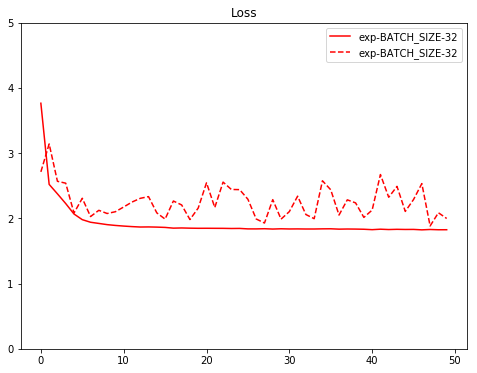

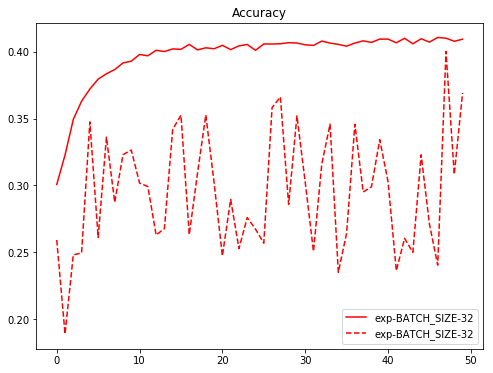

In [15]:
import matplotlib.pyplot as plt
%matplotlib inline
color_bar = ["r", "g", "b", "y", "m", "k"]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.ylim([0, 5])
plt.legend()
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend()
plt.show()